In [1]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *

import torch.linalg as LA

from models import *
from transformers import GPT2Model, GPT2Config
from notebook_utils import *

import matplotlib.pyplot as plt

In [48]:
mytf_tm, dataset = load_mytfs_model_and_dataset(
    num_vars = 16,
    attention_style = "softmax",
    do_layer_norm = False,
    seed = 508,
    chain_len_range = (3,3),
    num_rules_range = (8,12))

for k, v in mytf_tm.named_parameters():
    print(k)

mytf.af_blocks.0.attn_heads.0.Wq.weight
mytf.af_blocks.0.attn_heads.0.Wk.weight
mytf.af_blocks.0.attn_heads.0.Wv.weight
mytf.af_blocks.0.ffwd.0.weight
mytf.af_blocks.0.ffwd.2.weight


In [49]:
mytf = mytf_tm.mytf
af = mytf.af_blocks[0]
Wq, Wk, Wv = af.attn_heads[0].Wq, af.attn_heads[0].Wk, af.attn_heads[0].Wv
_Wq = Wq.weight.transpose(0,1).detach()
_Wk = Wk.weight.transpose(0,1).detach()
_Wv = Wv.weight.transpose(0,1).detach()

lin1 = af.ffwd[0]
lin2 = af.ffwd[2]
_lin1 = lin1.weight.detach()
_lin2 = lin2.weight.detach()

torch.tensor([
    [_Wq.min(), _Wq.max()],
    [_Wk.min(), _Wk.max()],
    [_Wv.min(), _Wv.max()],
    [_lin1.min(), _lin1.max()],
    [_lin2.min(), _lin2.max()]
])

tensor([[-1.4051,  1.3981],
        [-1.9918,  1.8774],
        [-1.2585,  1.3195],
        [-1.0144,  1.0946],
        [-0.6848,  0.8190]])

<Figure size 640x480 with 0 Axes>

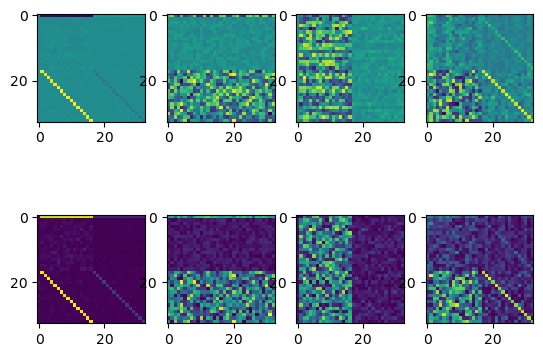

In [50]:
plt.clf()
fig, ax = plt.subplots(2,4)

ax[0,0].imshow((_Wq @ _Wk.transpose(0,1)).numpy())
ax[0,1].imshow(_Wq.numpy())
ax[0,2].imshow(_Wk.transpose(0,1).numpy())
ax[0,3].imshow(_Wv.numpy())

ax[1,0].imshow((_Wq @ _Wk.transpose(0,1)).abs().numpy())
ax[1,1].imshow(_Wq.abs().numpy())
ax[1,2].imshow(_Wk.transpose(0,1).abs().numpy())
ax[1,3].imshow(_Wv.abs().numpy())

<Figure size 640x480 with 0 Axes>

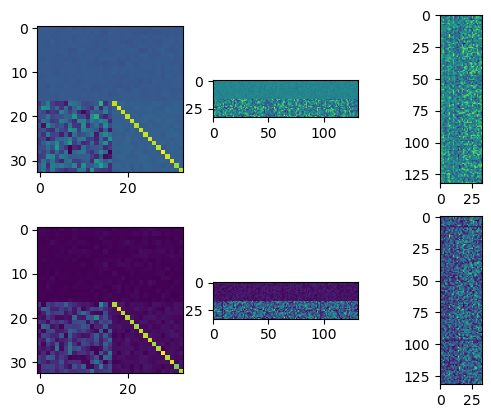

In [51]:
plt.clf()
fig, ax = plt.subplots(2,3)

ax[0,0].imshow((_lin2 @ _lin1).numpy())
ax[0,1].imshow(_lin2.numpy())
ax[0,2].imshow(_lin1.numpy())

ax[1,0].imshow((_lin2 @ _lin1).abs().numpy())
ax[1,1].imshow(_lin2.abs().numpy())
ax[1,2].imshow(_lin1.abs().numpy())

In [52]:
plt.clf()

<Figure size 640x480 with 0 Axes>

In [53]:
torch.manual_seed(101)
for item in DataLoader(dataset, batch_size=5):
    break

out = mytf_tm(**item)
pred = out.logits > 0
(pred == item["labels"]).float().mean(dim=-1).squeeze()

tensor([1., 1., 1., 1., 1.])

In [54]:
item["tokens"].shape

torch.Size([5, 15, 32])

In [55]:
tokens = item["tokens"]
x = torch.cat([
    torch.ones(tokens.size(0), tokens.size(1), 1),
    tokens
], dim=2)

wts, A = af(x)

# A = (Wq(x) @ Wk(x).transpose(1,2)).detach()
# wts = (A @ Wv(x)).detach()

# x_emb_norm = af.norm1(x_emb).detach()
# A = (Wq(x_emb_norm) @ Wk(x_emb_norm).transpose(1,2)).detach()
# wts = (A @ Wv(x_emb_norm)).detach()


In [56]:
item["labels"]

tensor([[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]])

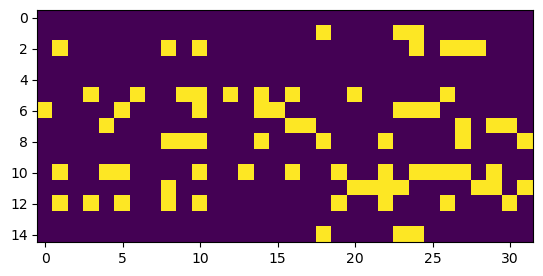

In [57]:
plt.imshow(tokens[-1].detach().numpy())

In [12]:
af.norm1, af.norm2, af.attn_heads[0].attention_style

(Identity(), Identity(), 'softmax')

In [62]:
Wa = nn.Linear(4,5)
Wa.weight

Parameter containing:
tensor([[-0.1684,  0.1509, -0.4263, -0.3477],
        [ 0.1028, -0.0580,  0.1882,  0.3567],
        [ 0.3391,  0.2924,  0.3598,  0.3265],
        [-0.0910,  0.4124, -0.4329,  0.0627],
        [ 0.4827,  0.0055,  0.2625,  0.0496]], requires_grad=True)

In [64]:
Wa.weight.data.fill_(1)
Wa.weight

Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)